In [1]:
import umap
from spacy.lang.de import German
from tqdm import tqdm
from spacy.lang.de.stop_words import STOP_WORDS
import pandas as pd
import json
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import seaborn as sns
from gensim.models import Word2Vec
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA

### Reading

In [2]:
de_nlp = German()

In [3]:
all_laws = []

In [4]:
with open("-f_new.txt", encoding='utf-8') as f:
    all_laws = f.readlines()
all_laws = [x.strip() for x in all_laws]

In [5]:
web_addresses = []
for line in all_laws:
    temp = line.split(' ')
    web_addresses.append(temp[1])

In [6]:
words = []
for address in web_addresses:
    temp = address.split('/')
    words.append(temp[4])

In [7]:
category = set()
for word in words:
    category.add(word)

In [8]:
category.remove('Erlaesse')
category.remove('LgblNO')

### Lemmatization

In [9]:
other_stopwords = [']','[','{','}','.',',',':','#','-','"','!','?','*','&','@','˝',')','(',';','´',' ','/']
other_words = ['comments','Kurztitel','Artikel','Text','text','Status','Kundmachungsorgan','pdf','dokument','SKIPPED','§','siehe']

In [10]:
def listToString(s):
    str1 = " "
    return (str1.join(s))

In [11]:
def lemmatize(sentence):
    temp = de_nlp(sentence)
    words = []
    for j, token in enumerate(temp):
        if not token.is_stop and token.text not in other_stopwords:
             words.append((token.lemma_))
    return words

In [12]:
data_list = []
for i, var in tqdm(enumerate(all_laws), 'Reading data'):
    if len(var) > 1000000:
        continue
    final = []
    categories = var.split('/')
    final.append(categories[4])
    final.append(var)
    final.append(len(var))
    final.append(len(var.split(" ")))
    data_list.append(final)
category_df = pd.DataFrame(data_list,columns=['Category','All_data','Length','Words'])

Reading data: 246755it [00:05, 49302.60it/s]


In [13]:
category_df = category_df[(category_df.Category != "Erlaesse") & (category_df.Category != "LgblNO")]

In [14]:
new_category_df = category_df[(category_df.Words > 21)]

In [15]:
all_category = []
all_data = []
for i, row in new_category_df.iterrows():
    all_category.append(row["Category"])
    all_data.append(row["All_data"])

In [16]:
data_list = []
for i, var in tqdm(enumerate(all_data), 'Token and Lemmatization'):
    if len(var) > 1000000:
        continue
    temp = json.loads(var)
    if "text" in temp:
        data_list.append(lemmatize(json.dumps(temp["text"], ensure_ascii=False)))
    else:
        data_list.append(lemmatize(var))

Token and Lemmatization: 246221it [12:55, 317.69it/s]


In [17]:
cleared_data = []
for i, var in tqdm(enumerate(data_list), "Clearing data"):
    temp = []
    for word in var:
        if word not in other_words:
            temp.append(word)
    cleared_data.append(temp)

Clearing data: 246221it [00:11, 21941.18it/s]


In [18]:
modell = Word2Vec(cleared_data,workers=5,iter=5)

In [ ]:
w1 = 'Nummer'
modell.wv.most_similar(positive=w1)

In [19]:
print(modell)

Word2Vec(vocab=247630, size=100, alpha=0.025)


In [ ]:
vectorizer = modell.wv
vocab_length = len(modell.wv.vocab)
vectors = [
            np.array([vectorizer[word] for word in tweet if word in modell]).flatten() for tweet in tqdm(cleared_data,'Vectorizing')
            ]

In [19]:
X = modell[modell.wv.vocab]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


2
3
4
5
6
7
8
9


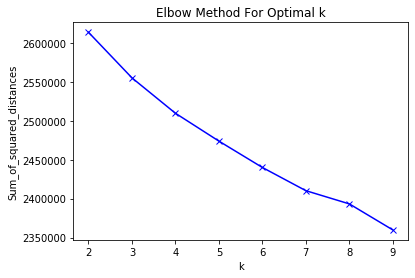

In [20]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    print(k)
    km = KMeans(n_clusters=k, max_iter=200, n_init=1)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=1)
model.fit(X)
labels=model.labels_
law_cl=pd.DataFrame(list(zip(list(category),labels)),columns=['category','cluster'])
print(law_cl.sort_values(by=['cluster']))

        category  cluster
8  Gemeinderecht        4
3   Landesnormen        5
4   Bundesnormen        5
5           RegV        5
7         Justiz        5
9    Normenliste        5
0           Vwgh        6
1          Begut        7
2           Vfgh        7
6           Lgbl        7


In [21]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=1)
model.fit(X)
labels=model.labels_
law_cl=pd.DataFrame(list(zip(list(category),labels)),columns=['category','cluster'])
print(law_cl.sort_values(by=['cluster']))

        category  cluster
1   Landesnormen        0
2          Begut        0
6           Vfgh        0
0           Lgbl        1
8   Bundesnormen        1
9    Normenliste        1
3  Gemeinderecht        2
4           RegV        2
5           Vwgh        2
7         Justiz        2


In [22]:
words = modell.wv.vocab.keys()
feature_names = list(words)

In [24]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = feature_names
for i in range(true_k):
    print ("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind]),
    print()

Top terms per cluster:
Cluster 0:
 Einhaltung
 bestimmen
 multinationalen
 Entwicklung
 FMP-Personals
 internationale
 Beteiligung
 Operation
 folgend
 beteiligen

Cluster 1:
 erforderlich
 Behörde
 Schutztruppe
 2
 Zivilbevölkerung
 III
 spät
 ausschließlich
 kundgemacht
 Regierung

Cluster 2:
 Entwicklung
 folgend
 Einhaltung
 3
 Gesetz
 multinationalen
 FMP-Personals
 anwendbar
 Beteiligung
 örtlich



Cluster: 0
Titles
  Begut
 Justiz
   Vwgh


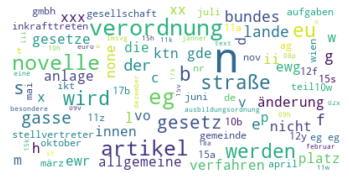

Cluster: 1
Titles
 Bundesnormen
         Lgbl
 Landesnormen


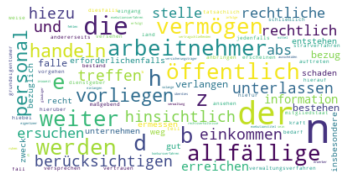

Cluster: 2
Titles
 Gemeinderecht
          RegV
          Vfgh
   Normenliste


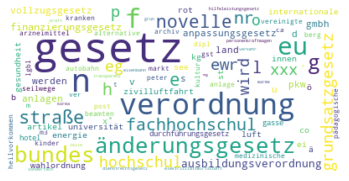

In [25]:
result={'cluster':labels,'law':feature_names}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['law'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=law_cl[law_cl.cluster==k]['category']         
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labelss = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labelss,
            s=50, cmap='viridis');

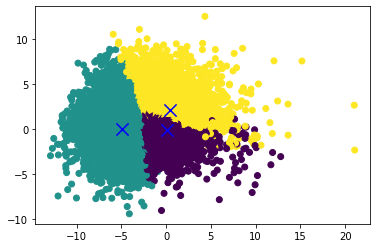

In [23]:
random_state = 0
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(modell.wv.vectors)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(modell.wv.vectors))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [ ]:
from yellowbrick.text import UMAPVisualizer
umap = UMAPVisualizer(labels=["category"], metric='cosine')
umap.fit(modell.wv.vectors)
umap.show()

In [ ]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.1, cmap='Spectral');

In [ ]:
from sklearn.datasets import fetch_openml


clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=20,
).fit_transform(modell.wv.vectors)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=mnist.target, s=0.1, cmap='Spectral');

In [24]:
random_state = 0
# reduce the features to 2D
umap = umap.UMAP(n_components=2,random_state=random_state)

In [ ]:
standard_embedding = umap.fit_transform(modell.wv.vectors)

In [ ]:
# reduce the cluster centers to 2D
reduced_cluster_centerss = umap.transform(model.cluster_centers_)
#plt.scatter(standard_embedding[:,0], standard_embedding[:,1], c=model.predict(modell.wv.vectors))
plt.scatter(reduced_cluster_centerss[:, 0], reduced_cluster_centerss[:,1], marker='x', s=150, c='b')